# DEBUG: NumPy ↔ TensorFlow feature parity

This notebook builds the patch stack **B** and computes features step by step with **NumPy**
and **TensorFlow**, comparing each intermediate using `np.allclose`.


In [17]:
# --- Setup ---
# %pip install tensorflow==2.16.* scikit-learn==1.4.* pandas openpyxl matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import tensorflow as tf
from ml_spatialfreq_utils import (
    TrainedModelTF, DBInfo, synth_fringe, peaks, calc_feature_batch
)

from ml_spatialfreq_utils_GPU import tf_calc_feature_batch

plt.rcParams["figure.figsize"] = (5.5, 4.2)

print('Imports OK')


Imports OK


In [18]:
# Check for GPUs

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    try:
        for d in tf.config.list_physical_devices('GPU'):
            tf.config.experimental.set_memory_growth(d, True)
    except Exception as e:
        print("Could not set memory growth:", e)

TensorFlow version: 2.16.2
Built with CUDA: False
GPU devices: []


In [19]:
# --- Resolve model paths from the DB Excel ---
rootFolderDB = Path('../local_data/ML_Models')              # Adjust if needed
db_name = 'DB-trainingSets-OM4M007.xlsx'        # Same as MATLAB
db_sheet = 'Sheet1'                             
trainingSet_Idx = 12                              # 1-based row index

db_path = rootFolderDB / db_name
print("Reading DB:", db_path.resolve())
db_tb = pd.read_excel(db_path, sheet_name=db_sheet)

row_idx = trainingSet_Idx - 1
assert 0 <= row_idx < len(db_tb), "trainingSet_Idx out of range"

row = db_tb.iloc[row_idx].to_dict()

# Expected columns for Python artifacts (preferred). If missing, you can fill them below.
kerasModelPath = rootFolderDB / row.get('trainedModel')
scalerPath     = rootFolderDB / row.get('scaler')
featureMetadataPath  = rootFolderDB / row.get('feature_metadata')
feature_name    = row.get('featureName')
patch_NR       = int(row.get('patch_NR'))
patch_NC       = int(row.get('patch_NC'))

print("kerasModel Name:", kerasModelPath)
print("scaler name    :", scalerPath)
print("feature_metadata name      :", featureMetadataPath)
print("feature Name   :", feature_name, " patch:", patch_NR, "x", patch_NC)


Reading DB: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\DB-trainingSets-OM4M007.xlsx
kerasModel Name: ..\local_data\ML_Models\trainedModel_07-10-2025_DB_feature_projected_DFT_13x13_GVN-0_NS-15000_28-Aug-2025.keras
scaler name    : ..\local_data\ML_Models\scaler_07-10-2025_DB_feature_projected_DFT_13x13_GVN-0_NS-15000_28-Aug-2025.pkl
feature_metadata name      : ..\local_data\ML_Models\feature_metadata_07-10-2025_DB_feature_projected_DFT_13x13_GVN-0_NS-15000_28-Aug-2025.json
feature Name   : feature_projected_DFT  patch: 13 x 13


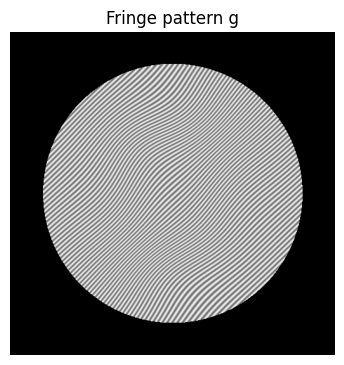

In [20]:

# --- Build or load a test fringe pattern (like the MATLAB script) ---
NR, NC = 511, 512
y, x = np.mgrid[0:NR, 0:NC]
y=y-0.5*NR; x=x-0.5*NC
R=0.4*NR

# M_ROI = np.ones_like(g, dtype=bool)  # full image ROI
M_ROI = np.abs(x + 1j*y)<R

w0_x, w0_y = np.pi/4, np.pi/4
psi = 3*peaks(NR, NC)
g, w_phi, phi_x, phi_y, theta = synth_fringe(NR, NC, w0_x, w0_y, psi, modulation=50, background=128, noise_std=2, return_maps=True)

plt.figure(); plt.imshow(g*M_ROI, cmap='gray'); plt.title('Fringe pattern g'); plt.axis('off'); plt.show()



In [21]:
#Load trained model and db info objects
dbi = DBInfo(featureName=str(feature_name), patch_NR=int(patch_NR), patch_NC=int(patch_NC))
trained_model = TrainedModelTF(model_path=kerasModelPath, scaler_path=scalerPath, meta_path=featureMetadataPath, DB_info=dbi)


In [22]:
def report_allclose(name, A, B, rtol=1e-4, atol=1e-5):
    A_np = A if isinstance(A, np.ndarray) else A.numpy()
    B_np = B if isinstance(B, np.ndarray) else B.numpy()
    ok = np.allclose(A_np, B_np, rtol=rtol, atol=atol, equal_nan=True)
    maxdiff = np.nanmax(np.abs(A_np - B_np)) if A_np.size and B_np.size else np.nan
    print(f"{name:25s} allclose={ok}  max|Δ|={maxdiff:.3e}  shapeA={A_np.shape} shapeB={B_np.shape}")
    return ok


## Build patch stack `B` using the legacy (NumPy) approach


In [23]:
# Phase 1: load trained model 

if M_ROI is None:
    M_ROI = np.ones_like(g, dtype=bool)
M_ROI = M_ROI.astype(bool)

model, scaler, meta = trained_model.load()
assert feature_name == trained_model.DB_info.featureName, "FeatureName does not match trained model"

# Phase 2: Feature extraction (GPU)
N = trained_model.DB_info.patch_NR
M = trained_model.DB_info.patch_NC
r = N//2; c = M//2  # center offset

NR, NC = g.shape
# Compute valid centers where an N x M patch fully lies in ROI.
# We'll use convolution with an N x M ones kernel to count ROI pixels per center.
from scipy.signal import convolve2d
Mvalid_counts = convolve2d(M_ROI.astype(np.uint8), np.ones((N,M), dtype=np.uint8), mode="same", boundary="fill")
full_area = int(N*M)
valid_centers = (Mvalid_counts == full_area)

# Avoid borders explicitly to keep N x M fully inside image bounds
if r > 0:
    valid_centers[:r, :] = False
    valid_centers[-r:, :] = False
if c > 0:
    valid_centers[:, :c] = False
    valid_centers[:, -c:] = False

ir, jc = np.where(valid_centers)
L = len(ir)
if L == 0:
    raise ValueError("number of blocks are 0")

# Extract patches into stack B (N x M x L)
B = np.zeros((N, M, L), dtype=np.float32)
for k in range(L):
    i = ir[k]; j = jc[k]
    B[:,:,k] = g[i-r:i-r+N, j-c:j-c+M]

# Step-by-step features (NumPy ground truth)


## numpy features (TensorFlow) — exact mirror

In [24]:
X_np, S_np = calc_feature_batch(B, feature_name)

## tensor flow features (TensorFlow) — exact mirror

In [37]:
B_tf = tf.cast(B, tf.float64)
X_tf, S_tf = tf_calc_feature_batch(B_tf, feature_name)

## Compare intermediates with `np.allclose`


In [38]:
ok = True
ok &= report_allclose('W',           S_np['W'], S_tf['W'])
ok &= report_allclose('mu_sp',        S_np['mu_sp'], S_tf['mu_sp'])
ok &= report_allclose('Bwin',        S_np['Bwin'], S_tf['Bwin'], atol=1e-4)
ok &= report_allclose('G_abs',        S_np['G_abs'], S_tf['G_abs'])
ok &= report_allclose('G',        S_np['G'], S_tf['G'])



print('\nALL OK =', bool(ok))


W                         allclose=True  max|Δ|=5.228e-08  shapeA=(13, 13) shapeB=(13, 13)
mu_sp                     allclose=True  max|Δ|=4.095e-05  shapeA=(1, 1, 121588) shapeB=(1, 1, 121588)
Bwin                      allclose=True  max|Δ|=4.214e-05  shapeA=(13, 13, 121588) shapeB=(13, 13, 121588)
G_abs                     allclose=False  max|Δ|=5.206e+05  shapeA=(13, 13, 121588) shapeB=(13, 13, 121588)
G                         allclose=False  max|Δ|=5.206e+05  shapeA=(13, 13, 121588) shapeB=(13, 13, 121588)

ALL OK = False


### First problem 
the FFT mismatch is because tf.signal.fft2d always transforms the last two axes, while your NumPy call transforms axes (0,1) of an array with shape (N, M, L).

-NumPy: np.fft.fft2(Bwin_np, axes=(0,1)) → FFT over the first two axes (N, M), treating L as batch.

-TensorFlow: tf.signal.fft2d(Bwin_tf) → FFT over the innermost two axes. With shape (N, M, L), TF will transform axes (M, L), which is wrong for your case.

That explains the huge difference you see even though Bwin matches within tolerance.

In [ ]:
Bwin_np= S_np['Bwin']
Bwin_tf= S_tf['Bwin']
report_allclose('Bwin',  Bwin_np, Bwin_tf, atol=1e-4)

G_tf = tf.signal.fft2d(tf.cast(Bwin_tf, tf.complex64)) 
G_np = np.fft.fft2(Bwin_np, axes=(0, 1))
report_allclose('G', G_np, G_tf)



Bwin                      allclose=True  max|Δ|=4.214e-05  shapeA=(13, 13, 121588) shapeB=(13, 13, 121588)
G                         allclose=False  max|Δ|=8.685e+05  shapeA=(13, 13, 121588) shapeB=(13, 13, 121588)


False

In [41]:
# send the two first axes to the innermost dimmnesions
B_chw = tf.transpose(Bwin_tf, perm=[2, 0, 1])                      # (L,N,M)
G_chw = tf.signal.fft2d(tf.cast(B_chw, tf.complex64))
G_tf = tf.transpose(G_chw, perm=[1, 2, 0])                         # (N,M,L)
report_allclose('G', G_np, G_tf, atol=1e-2)

G                         allclose=True  max|Δ|=3.602e-03  shapeA=(13, 13, 121588) shapeB=(13, 13, 121588)


True